## Reacciones y condensación

Este código calcula la evolución del nro de partículas de cada especie en función del tiempo dentro de la burbuja considerando distintos fenómenos:
* Reacciones
* Condensación

### Importo dependencias

In [1]:
#Importo dependencias
import scipy
import pandas as pd
import numpy as np
import math
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [2]:
#Código necesario para importar funciones de otros notebooks .ipynb

import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path

class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod


class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

sys.meta_path.append(NotebookFinder())

#Ejemplo
# from derivada_reacciones import *

In [3]:
#Importo notebooks

from parametros import *
from reacciones_qcas import *
from funciones_math import fact, erf
from condensacion_y_evaporacion import *
from funciones_qcas import *

importing Jupyter notebook from parametros.ipynb
1.673557692882144e-27
importing Jupyter notebook from reacciones_qcas.ipynb
importing Jupyter notebook from funciones_math.ipynb
importing Jupyter notebook from condensacion_y_evaporacion.ipynb
importing Jupyter notebook from conductividad_termica.ipynb
importing Jupyter notebook from funciones_qcas.ipynb


### Parámetros de la evolucicón

#### Condiciones iniciales

In [4]:
#Condiciones iniciales
#Orden:
#n[n_species] = {n[0],     n[1],   n[2],   n[3],   n[4],   n[5],   n[6],   n[7]}
#n[n_species] =      {H2,       H,      O,      O2,     OH,     H2O,    H2O2,   HO2}
#n0[n_species] = {0.0,   0.0,   0.5e8,    0.5e8,  0.0}
#n0 = np.array([1.0e8,   0.0,    0.0,    1.0e8,  0.0])
n0 = np.array([1.0e8,   0.0,    0.0,    1.0e8,  0.0,    1.0e8,    0.0,    0.0])




In [5]:
#Funciones químicas




#Función de control durante la evolución

def imprimir_nro_particulas(n_species,n,t, m0):
    #Imprime el tiempo, el nro de partículas de cada especie y la masa normalizada a la masa inicial.
    print(t, "\t", n[0], "\t", n[1], "\t", n[2], "\t", n[3], "\t", n[4], "\t", n[5], "\t", n[6], "\t", n[7], "\t", masa(n)/m0)


In [6]:
#Calculo la masa inicial
m0 = masa(n0)

In [7]:
#Importo funciones
from parametros import R, Vol, T, v_R, rapidez, var_termo
from reacciones_qcas import derivada_reacc_qcas
from condensacion_y_evaporacion import derivada_condensacion
from funciones_qcas import masa
#Importo constantes
from parametros import n_species, n_var_termo
from conductividad_termica import calculamp


In [8]:

def derivada(t, n):
    #Calculo la derivada dndt
    dndt = np.zeros(n_species)

    #Actualizo las variables termodinámicas
    #y = [R(t), v_R(t), m, mp, T, Tp, pB, pBp]
    y = np.zeros(n_var_termo)

    y[var_termo["R"]]= R(t)
    y[var_termo["v_R"]]= v_R(t)
    y[var_termo["m"]] = masa(n)

    nAr = 0 #Consideramos que no hay Argón
    nh2o0 = n0[5]
    
    y[var_termo["T"]] = T(t)
    y[var_termo["pB"]] = 0
    
    y[var_termo["mp"]] = calculamp(t , y, n, rapidez, nh2o0, nAr)
    

    derivada_reacc_qcas(y,n,dndt)
    derivada_condensacion(t,y,n,dndt)

    imprimir_nro_particulas(n_species,n,t, m0)

    
    return dndt

In [9]:


#Creo el vector de nro de partículas y lo inicializo
n = np.zeros(n_species)
for i in range(n_species):
    n[i] = n0[i]

#Creo el vector de variables termodinámicas
y = np.zeros(n_var_termo)


t0=0.0; #Inicializacion del tiempo
    
#Creo el vector de dndt y lo inicializo
dndt = np.zeros(n_species)
dndt = derivada(t0, n)



    # //Creo el file en el que voy a ir guardando todo
    # ofstream file(archivo);
    # file << encabezado << endl;

imprimir_nro_particulas(n_species, n, t0, m0) #imprimo la cantidad inicial de partículas de cada especie
#step es el htry, es decir, el salto que (intenta hacer?) el rkqc.

#-------------------------------------------------------------------------------------------------------------------------
#SOLUCIÓN NUMÉRICA EMPLEANDO EL MÉTODO Radau
soln = solve_ivp(derivada, [t0, tmax], n0, method='Radau')
#Considerando condensación, no terminó de ejecutarse al cabo de 20' con tmax = 100e-6


0.0 	 100000000.0 	 0.0 	 0.0 	 100000000.0 	 0.0 	 100000000.0 	 0.0 	 0.0 	 1.0
0.0 	 100000000.0 	 0.0 	 0.0 	 100000000.0 	 0.0 	 100000000.0 	 0.0 	 0.0 	 1.0
0.0 	 100000000.0 	 0.0 	 0.0 	 100000000.0 	 0.0 	 100000000.0 	 0.0 	 0.0 	 1.0
1.4964415403265914e-23 	 99999999.99999645 	 1.5221616389063622e-05 	 1.4426454560337916e-06 	 99999999.99999928 	 8.137639005656059e-06 	 99999999.99999185 	 0.0 	 0.0 	 0.9999999999999999
0.0 	 99999998.50988388 	 0.0 	 0.0 	 100000000.0 	 0.0 	 100000000.0 	 0.0 	 0.0 	 0.9999999989291478
0.0 	 100000000.0 	 1.4901161193847656e-14 	 0.0 	 100000000.0 	 0.0 	 100000000.0 	 0.0 	 0.0 	 1.0
0.0 	 100000000.0 	 0.0 	 1.4901161193847656e-14 	 100000000.0 	 0.0 	 100000000.0 	 0.0 	 0.0 	 1.0
0.0 	 100000000.0 	 0.0 	 0.0 	 99999998.50988388 	 0.0 	 100000000.0 	 0.0 	 0.0 	 0.9999999914936953
0.0 	 100000000.0 	 0.0 	 0.0 	 100000000.0 	 1.4901161193847656e-14 	 100000000.0 	 0.0 	 0.0 	 1.0
0.0 	 100000000.0 	 0.0 	 0.0 	 100000000.0 	 0.0 	 999

In [10]:
print(soln) #para obtener info. sobre cómo fue la integración numérica

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 1274
     njev: 68
      nlu: 260
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 1.49644154e-21, 1.64608569e-20, 1.66105011e-19,
       1.66254655e-18, 1.66269620e-17, 1.66271116e-16, 1.66271266e-15,
       1.45171283e-14, 5.05456441e-14, 1.19109727e-13, 2.23607034e-13,
       3.67574368e-13, 5.77233934e-13, 9.02549529e-13, 1.45102051e-12,
       2.48466105e-12, 3.83621353e-12, 5.85237056e-12, 8.79113969e-12,
       1.37284174e-11, 2.18860964e-11, 3.26308900e-11, 4.93355748e-11,
       7.15991887e-11, 1.05086173e-10, 1.46613442e-10, 2.00011698e-10,
       2.74861578e-10, 3.71565263e-10, 4.80828620e-10, 6.06034567e-10,
       7.76830851e-10, 9.77681805e-10, 1.22243445e-09, 1.47786817e-09,
       1.71743342e-09, 1.92504182e-09, 2.14991140e-09, 2.39145488e-09,
       2.64156851e-09, 2.90462417e-09, 3.18716516e-09, 3.49690620e-09,
       3.87023090e-09, 4.27165936e-0

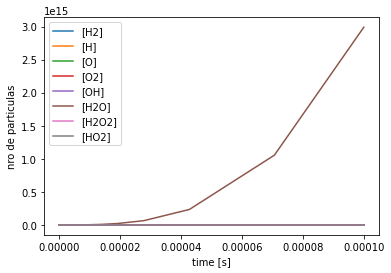

2485398883.259361


In [11]:
#plt.figure(dpi=1200) #Para mayor resolución
plt.plot(soln.t, soln.y[0], label='[H2]')
plt.plot(soln.t, soln.y[1], label='[H]')
plt.plot(soln.t, soln.y[2], label='[O]')
plt.plot(soln.t, soln.y[3], label='[O2]')
plt.plot(soln.t, soln.y[4], label='[OH]')
plt.plot(soln.t, soln.y[5], label='[H2O]')
plt.plot(soln.t, soln.y[6], label='[H2O2]')
plt.plot(soln.t, soln.y[7], label='[HO2]')
plt.xlabel('time [s]')
plt.ylabel('nro de particulas')
plt.legend()
plt.show()

print(soln.y[0,-1])
#243953033.74080586
#243953033.74080586
#243953033.74080586

#Cambié algunos parámetros de H a Deuterio
#243921159.20272547
#243921159.20272547
#No sé qué cambió acá. Estaba trabajando sobre la funcion derivada_condensacion y derivada_calculomp_formal. Voy a asumir que el cambio se debió a cuando modifiqué H por D:
#2466608559.2100945
#2466608559.2100945
#2466608559.2100945
#2466608559.2100945
#Cambié las masas de H a las de D
# 2466593301.4378543
# 2466593301.4378543
# 2466593301.4378543
# Me fui a almorzar y al volver cambió ligeramente. No sé por qué
# 2466593303.782749
# 2466593303.782749
# 2466593303.782749
# 2466593303.782749
# Cambié el parámetro rapidez = 1 a rapidez = 0
# 2485399653.851893
# 2485399653.851893
# 2485399653.851893
# 2485399653.851893
# 2485399653.851893
# 2485399653.851893
# 2485399653.851893


#2485399653.851893
#2485399653.851893
#Cambio Vol por v_R en y (es lo que debería ser)}
#2485399653.851893
#quedó el mismo valor
#2485399653.851893
#2485399653.851893
# El nro cambió porque modifiqué el cálculo de ntot en reacciones_qcas.ipynb. Lo cambié por una cuenta más rápida con numpy. Le creo a numpy
#2485398883.259361
#2485398883.259361
#2485398883.259361

In [12]:
print(np.sum(n))




300000000.0


In [13]:
ntot = 0.0
for i in range(n_species):
    ntot = ntot + n[i]
print(ntot)

300000000.0


In [14]:
test()

NameError: name 'test' is not defined